In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import random

# --- Plotting Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Notebook Setup ---
# Set a nice style for the plots
sns.set_style("whitegrid")
# Set a default size for the plots
plt.rcParams['figure.figsize'] = (14, 7)
# For progress bars in pandas apply
from tqdm.notebook import tqdm
tqdm.pandas()

print("Libraries imported and notebook style is set.")

Libraries imported and notebook style is set.


In [2]:
# --- Load Data ---
METADATA_PATH = Path(r"C:\Users\HP\Desktop\droneaimodel\final_dataset_ready_for_training\metadata.csv")

if not METADATA_PATH.exists():
    print(f"ERROR: Metadata file not found at '{METADATA_PATH}'")
    print("Please make sure this notebook is in the same folder as your metadata.csv")
else:
    df = pd.read_csv(METADATA_PATH)
    print("Metadata.csv loaded successfully.")
    print(f"Total records found: {len(df)}")
    
    # Display the first few rows to confirm it's loaded correctly
    display(df.head())

Metadata.csv loaded successfully.
Total records found: 27222


image_path  \
0  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
1  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
2  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
3  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
4  C:\Users\HP\Desktop\droneaimodel\final_dataset...   

                                           mask_path      class  split  
0  C:\Users\HP\Desktop\droneaimodel\final_dataset...  non_crack  train  
1  C:\Users\HP\Desktop\droneaimodel\final_dataset...  non_crack  train  
2  C:\Users\HP\Desktop\droneaimodel\final_dataset...  non_crack  train  
3  C:\Users\HP\Desktop\droneaimodel\final_dataset...  non_crack  train  
4  C:\Users\HP\Desktop\droneaimodel\final_dataset...  non_crack  train

In [5]:
# --- Sanity Checks ---
print("--- Running Data Sanity Checks ---")

# 1. Check for Missing Values
missing_values = df.isnull().sum().sum()
print(f"\n[Check 1] Missing Values: {'PASS' if missing_values == 0 else 'FAIL'}")
if missing_values > 0:
    print(df.isnull().sum())

# 2. Check for Duplicate Rows
duplicates = df.duplicated().sum()
print(f"\n[Check 2] Duplicate Rows: {'PASS' if duplicates == 0 else 'FAIL'}")
if duplicates > 0:
    print(f"  - Found {duplicates} duplicate rows.")

# 3. Check for Label Consistency
expected_classes = {'crack', 'non_crack'}
actual_classes = set(df['class'].unique())
expected_splits = {'train', 'validation', 'test'}
actual_splits = set(df['split'].unique())

print(f"\n[Check 3] Label Consistency: {'PASS' if actual_classes.issubset(expected_classes) and actual_splits == expected_splits else 'FAIL'}")
print(f"  - Found Classes: {actual_classes}")
print(f"  - Found Splits: {actual_splits}")

--- Running Data Sanity Checks ---

[Check 1] Missing Values: PASS

[Check 2] Duplicate Rows: PASS

[Check 3] Label Consistency: PASS
  - Found Classes: {'non_crack', 'crack'}
  - Found Splits: {'train', 'validation', 'test'}


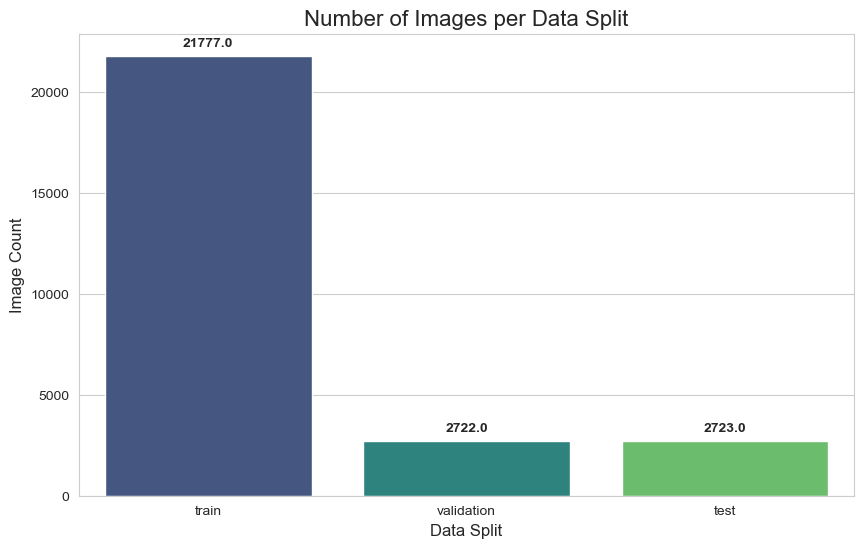

In [7]:
# --- Plot 1: Split Distribution ---
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='split', data=df, order=['train', 'validation', 'test'], 
                   hue='split', palette='viridis', legend=False)
ax.set_title('Number of Images per Data Split', fontsize=16)
ax.set_xlabel('Data Split', fontsize=12)
ax.set_ylabel('Image Count', fontsize=12)
# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')
plt.show()

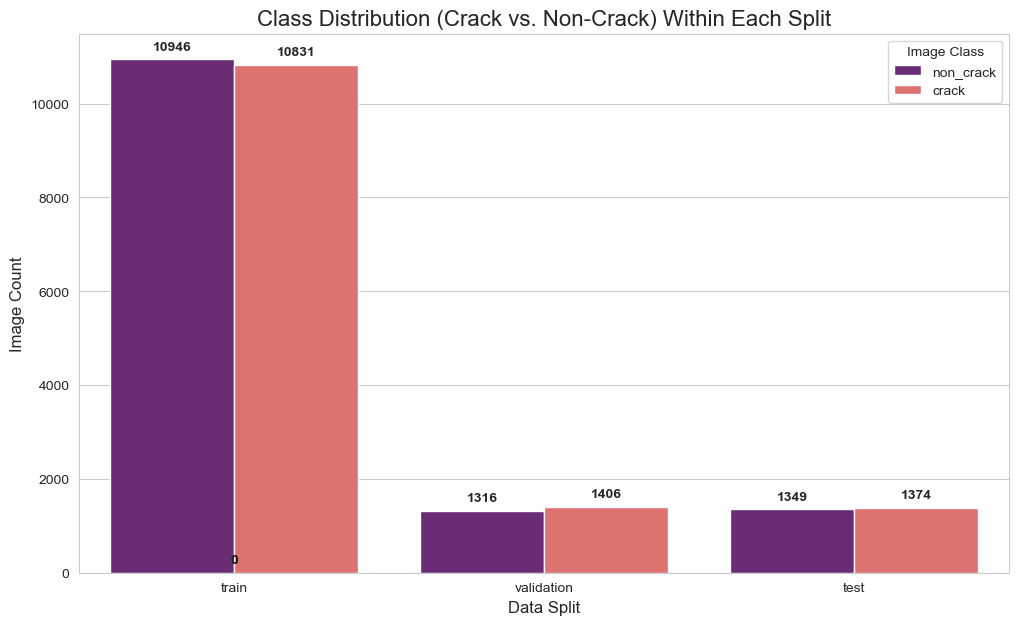


--- Class Distribution Analysis ---
class       crack  non_crack
split                       
test         1374       1349
train       10831      10946
validation   1406       1316

--- Class Balance Percentages ---
class                  crack  non_crack
split      split                       
test       test        50.46      49.54
train      train       49.74      50.26
validation validation  51.65      48.35

--- Overall Class Distribution ---
class
non_crack    13611
crack        13611
Name: count, dtype: int64
Overall Balance: 100.0% crack vs non-crack ratio


In [9]:
# --- Plot 2: Class Balance ---
plt.figure(figsize=(12, 7))
ax = sns.countplot(x='split', hue='class', data=df, order=['train', 'validation', 'test'], palette='magma')
ax.set_title('Class Distribution (Crack vs. Non-Crack) Within Each Split', fontsize=16)
ax.set_xlabel('Data Split', fontsize=12)
ax.set_ylabel('Image Count', fontsize=12)
plt.legend(title='Image Class')

# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), 
                textcoords='offset points', weight='bold')

plt.show()

# Print detailed class distribution statistics
print("\n--- Class Distribution Analysis ---")
class_split_counts = df.groupby(['split', 'class']).size().unstack(fill_value=0)
print(class_split_counts)

print("\n--- Class Balance Percentages ---")
class_split_pct = df.groupby(['split', 'class']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack(fill_value=0)
print(class_split_pct.round(2))

print("\n--- Overall Class Distribution ---")
overall_class_dist = df['class'].value_counts()
print(overall_class_dist)
print(f"Overall Balance: {(overall_class_dist.values[1]/overall_class_dist.values[0]*100):.1f}% crack vs non-crack ratio")

In [3]:
# --- Analysis 1: Dimension Check ---
print("--- Verifying Image Dimension Consistency ---")
num_to_check = 50
errors_found = 0
correct_shape_image = (512, 512, 3)
correct_shape_mask = (512, 512)

sample_df = df.sample(num_to_check)

for index, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Checking dimensions"):
    img = cv2.imread(row['image_path'])
    mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
    if img.shape != correct_shape_image or mask.shape != correct_shape_mask:
        errors_found += 1

print(f"\nChecked {num_to_check} random image/mask pairs.")
if errors_found == 0:
    print(f"\n✅ PASS: All checked images are {correct_shape_image} and masks are {correct_shape_mask}.")
else:
    print(f"\n❌ FAIL: Found {errors_found} files with incorrect dimensions.")

--- Verifying Image Dimension Consistency ---


Checking dimensions:   0%|          | 0/50 [00:00<?, ?it/s]


Checked 50 random image/mask pairs.

✅ PASS: All checked images are (512, 512, 3) and masks are (512, 512).


--- Analyzing Pixel-Level Imbalance in Crack Images ---


  0%|          | 0/2000 [00:00<?, ?it/s]

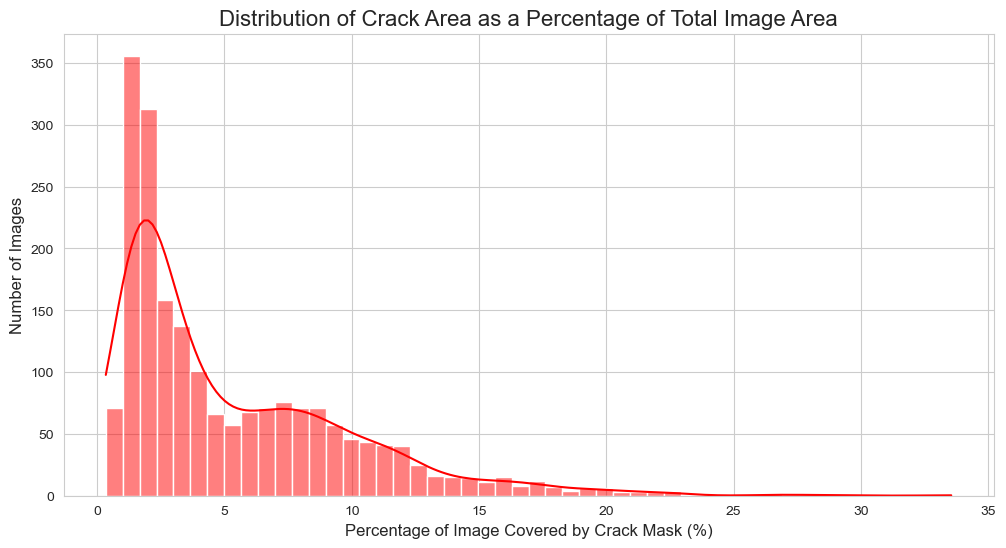


This plot shows that for most 'crack' images, the crack itself covers a very small percentage of the total area.
This confirms the extreme pixel-level imbalance and justifies using a loss function like Focal Tversky Loss.


In [4]:
# --- Plot 3: Pixel-Level Imbalance ---
print("--- Analyzing Pixel-Level Imbalance in Crack Images ---")

# We only need to analyze the 'crack' images for this
crack_df = df[df['class'] == 'crack'].copy()

# This can be slow, so we'll analyze a random sample of 2000 crack masks
sample_size = min(2000, len(crack_df))
crack_sample = crack_df.sample(sample_size)

def get_crack_pixel_percentage(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None: return 0
    return (cv2.countNonZero(mask) / mask.size) * 100

# Use progress_apply to show a progress bar
crack_sample['crack_percent'] = crack_sample['mask_path'].progress_apply(get_crack_pixel_percentage)

# Plot the histogram
plt.figure(figsize=(12, 6))
ax = sns.histplot(crack_sample['crack_percent'], bins=50, kde=True, color='red')
ax.set_title('Distribution of Crack Area as a Percentage of Total Image Area', fontsize=16)
ax.set_xlabel('Percentage of Image Covered by Crack Mask (%)', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
plt.show()

print("\nThis plot shows that for most 'crack' images, the crack itself covers a very small percentage of the total area.")
print("This confirms the extreme pixel-level imbalance and justifies using a loss function like Focal Tversky Loss.")


--- Displaying 4 random CRACK samples ---


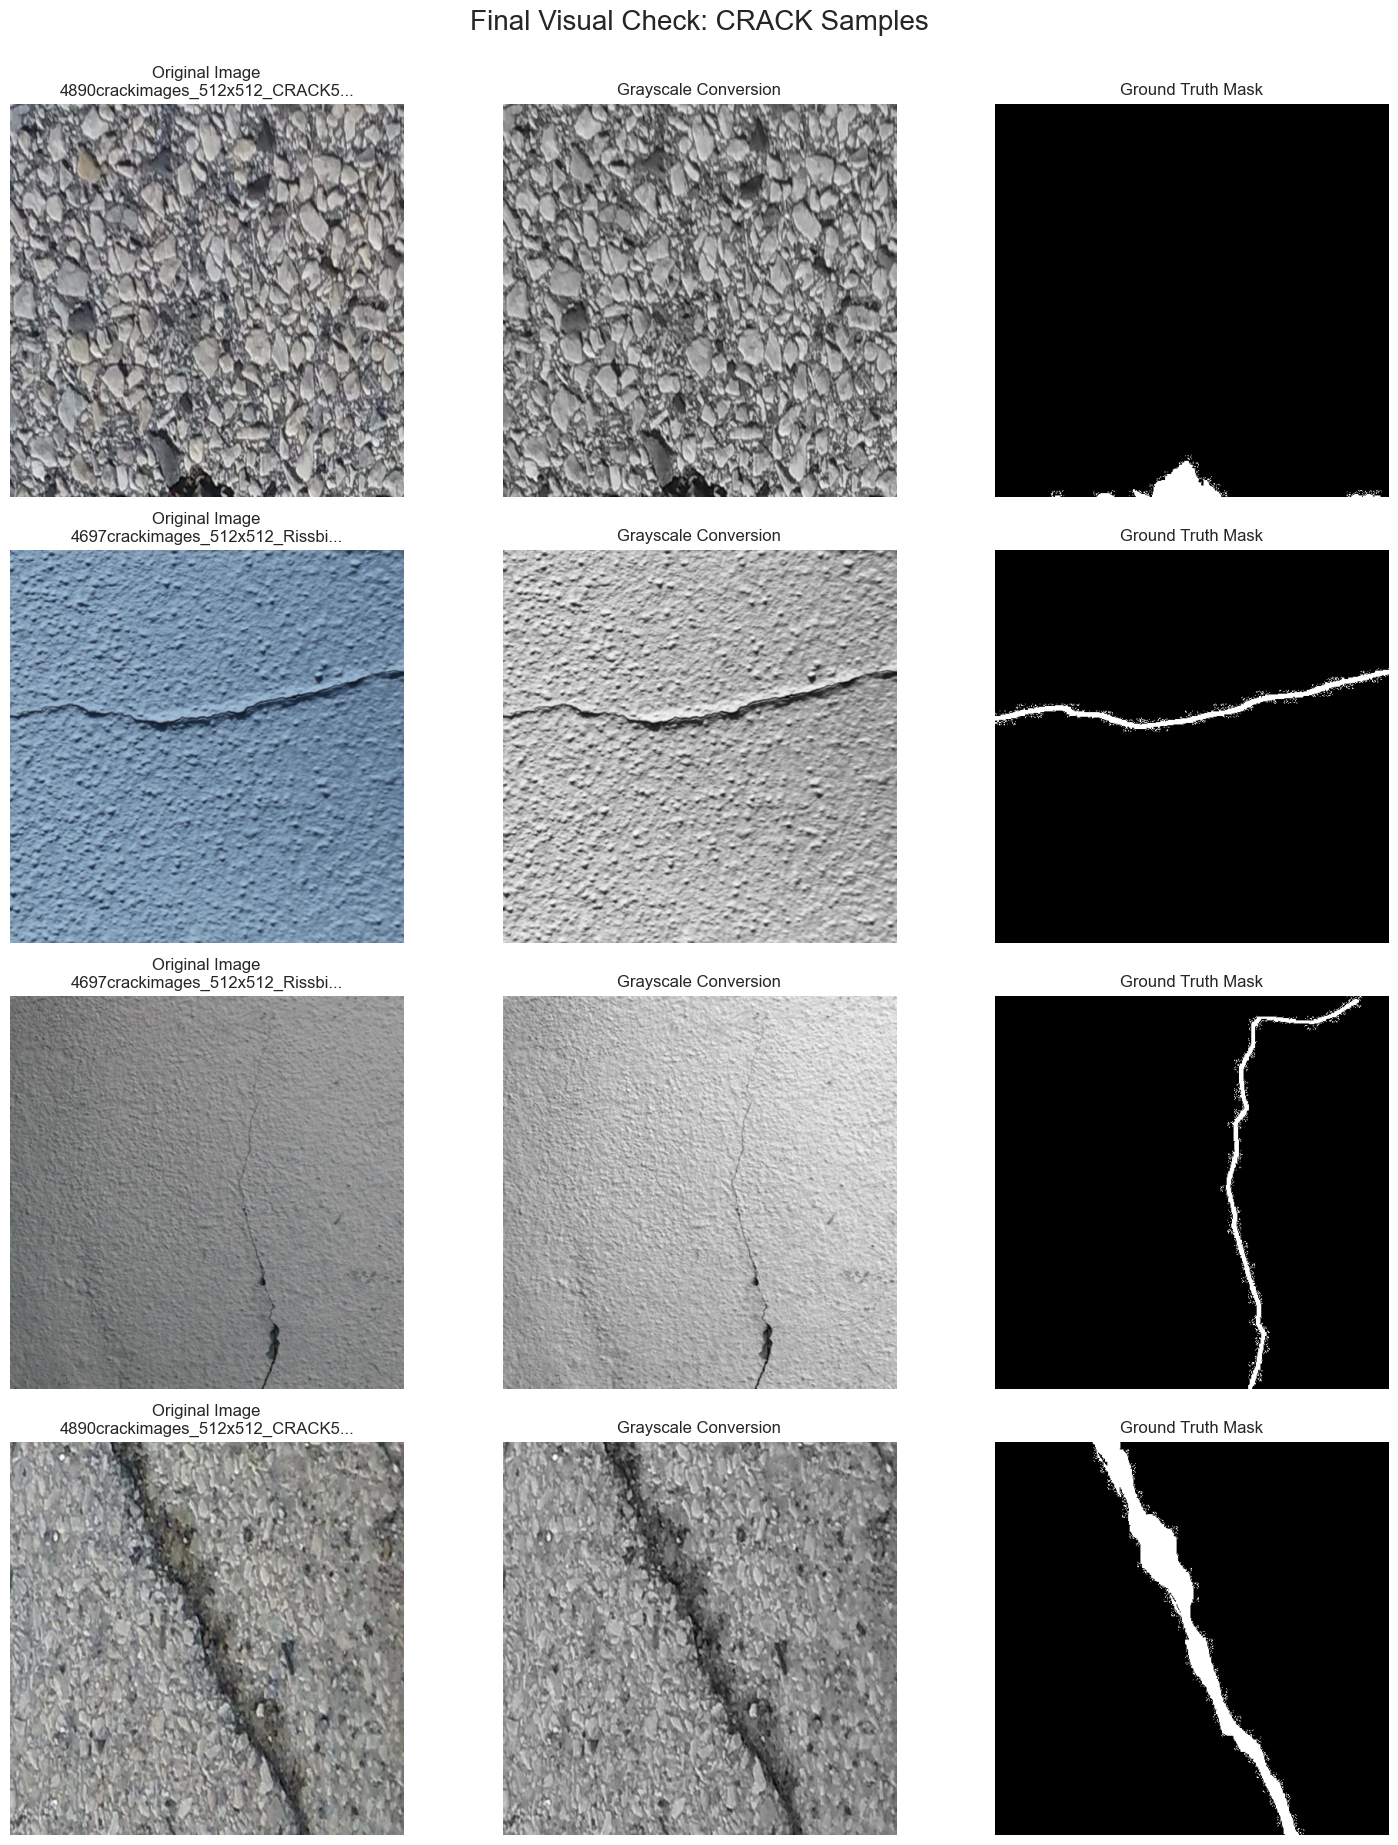


--- Displaying 4 random NON-CRACK samples ---


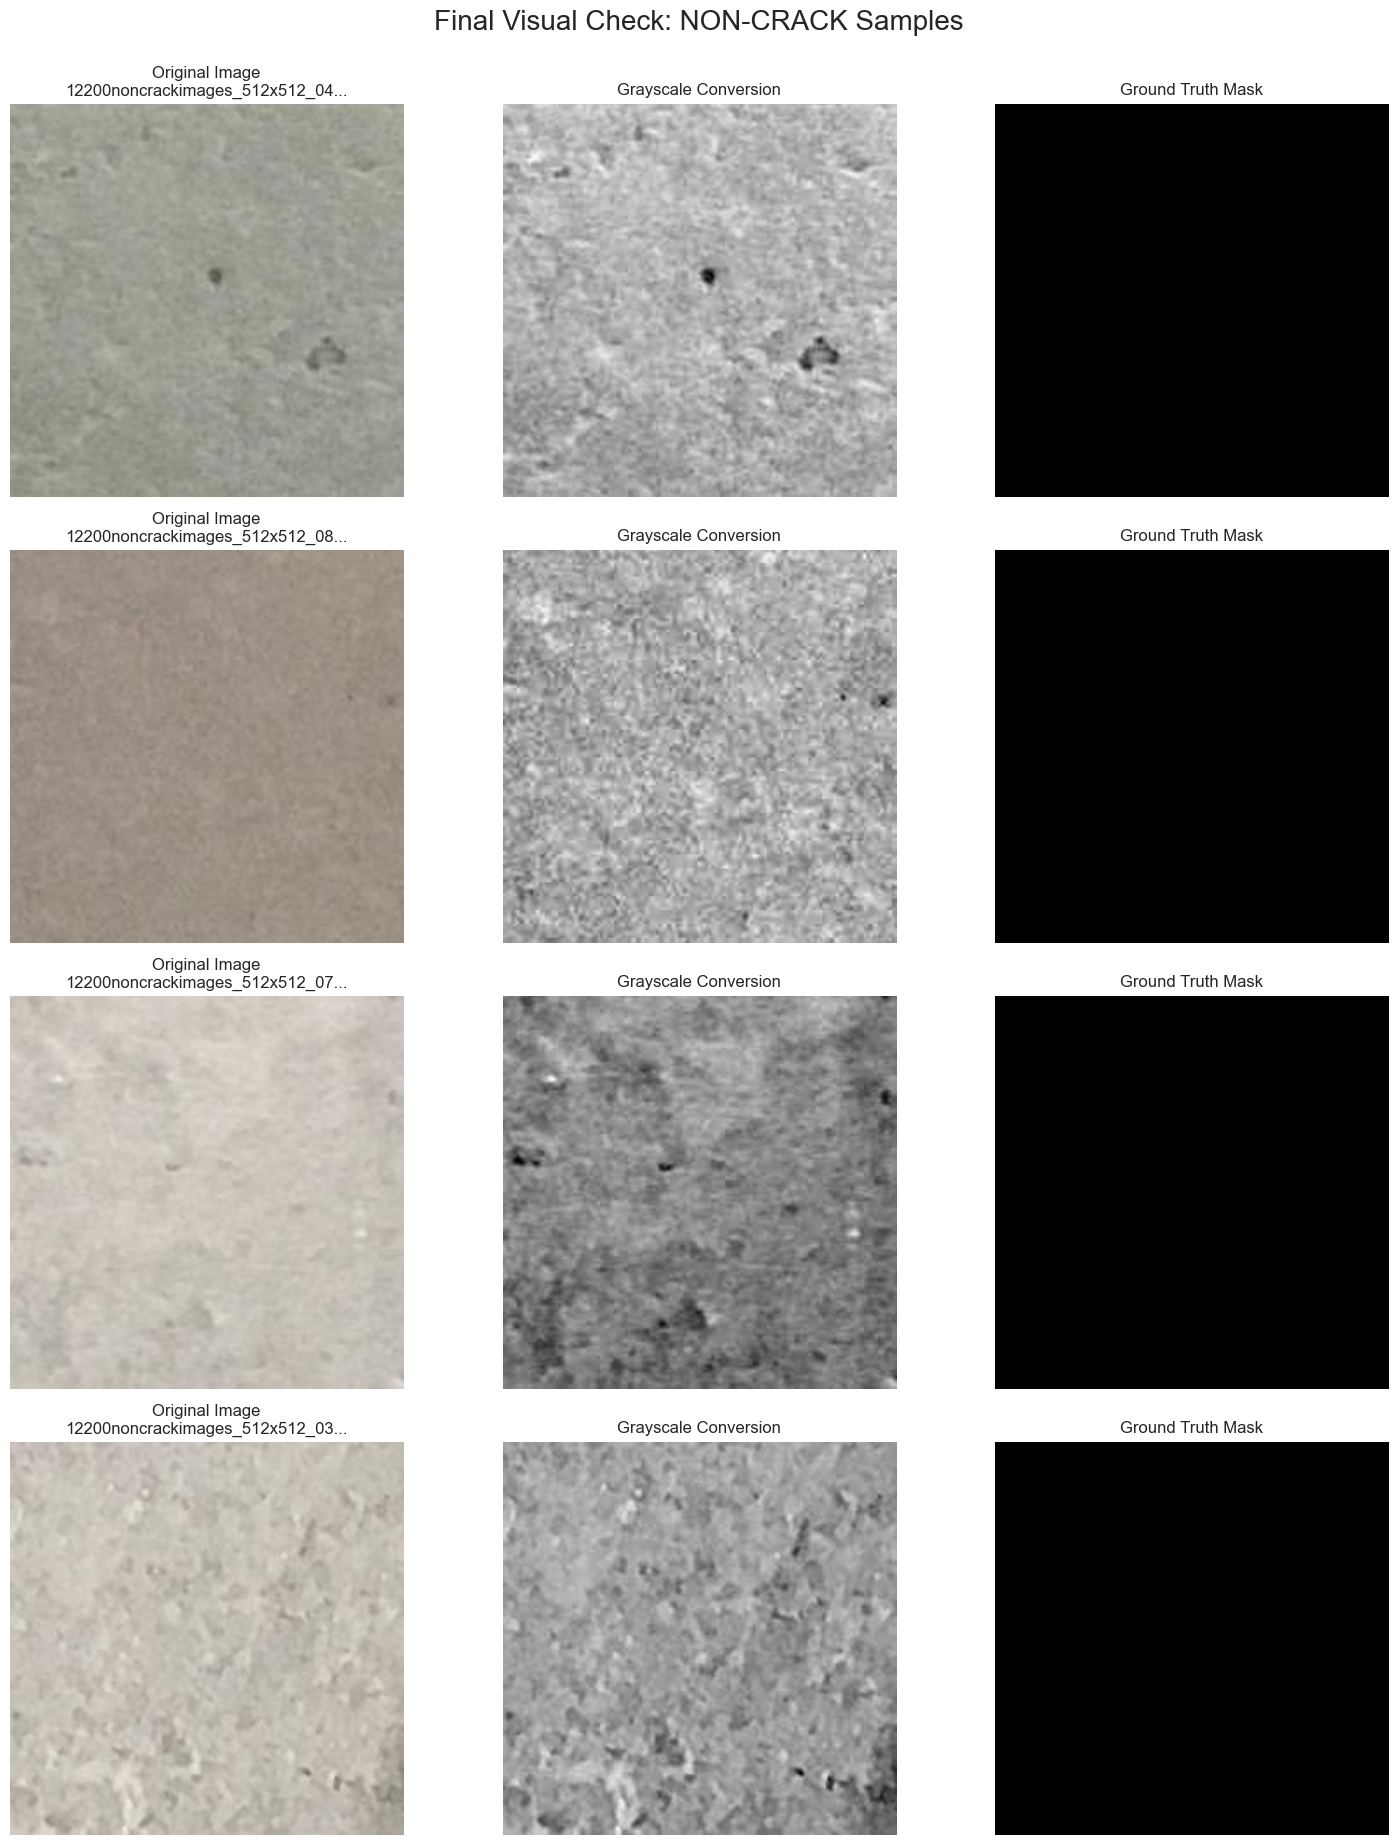

In [5]:
# --- Plot 4: Final Visual Verification ---

def display_final_samples(dataframe, num_samples, title):
    """Selects and displays random samples for final visual check."""
    sample_df = dataframe.sample(min(len(dataframe), num_samples))
    
    plt.figure(figsize=(15, num_samples * 5))
    plt.suptitle(title, fontsize=20, y=0.95)

    for i, (index, row) in enumerate(sample_df.iterrows()):
        # Original Image
        ax = plt.subplot(num_samples, 3, i * 3 + 1)
        img = cv2.imread(row['image_path'])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f"Original Image\n{Path(row['image_path']).name[:30]}...")
        plt.axis('off')

        # Grayscale Version
        ax = plt.subplot(num_samples, 3, i * 3 + 2)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.imshow(gray_img, cmap='gray')
        plt.title("Grayscale Conversion")
        plt.axis('off')
        
        # Mask
        ax = plt.subplot(num_samples, 3, i * 3 + 3)
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Execution ---
NUM_TO_SHOW = 4 # You can change this number

print(f"\n--- Displaying {NUM_TO_SHOW} random CRACK samples ---")
display_final_samples(df[df['class'] == 'crack'], NUM_TO_SHOW, "Final Visual Check: CRACK Samples")

print(f"\n--- Displaying {NUM_TO_SHOW} random NON-CRACK samples ---")
display_final_samples(df[df['class'] == 'non_crack'], NUM_TO_SHOW, "Final Visual Check: NON-CRACK Samples")